# Code template for hand-in on reconstruction attacks.

Advanced Topics in Machine Learning, U. Copenhagen, fall 2024

Created by Rasmus Pagh with minor edits by Thomas Christensen

Queries on a hidden dataset x from {-1,+1}^100 can be made via the query method below
which calls a web API that allows dot product queries with vectors in {-1,+1}^100.
To protect data, Laplace noise is added to responses. Using the techniques you have
seen in the lecture it is possible to partially reconstruct the dataset using 200 queries.
To make sure that you get a unique challenge, choose any unique string as your challenge
identifier. The web API will keep track of the number of queries made for each identifier.

# Support function for querying the web API

In [14]:
import numpy as np
import requests as rq

# Retrieve answer to challenge for a given query
def query(challenge_id, query_vector, submit=False):
    # Only alphanumeric challenge_id and vextor entries in {-1,+1} are allowed:
    assert(challenge_id.isalnum())
    assert(np.max(np.minimum(np.abs(query_vector-1),np.abs(query_vector+1)))==0)

    # if query array is 1d, make it 2d
    if query_vector.ndim == 1:
        query_vector = query_vector.reshape(1,-1)

    payload = { 'challengeid': challenge_id, 'submit': submit,
                'query': str(query_vector.tolist()) }
    response = rq.post("https://baconbreaker.pythonanywhere.com/query", data = payload).json()
    if submit == False:
        return np.array(eval(response['result']))
    else:
        return response['result']
print("ok")

ok


# Making random queries to the API

In [15]:
challenge_id = 'RunxingJia78911' # identifier for hidden dataset
n = 100 # number of entries in hidden dataset
num_queries = 2*n # number of queries to be asked

queries = np.random.choice([-1,+1], size=(num_queries,n)) # Set of random queries
print(queries)
query_results = query(challenge_id, queries)

print(query_results)


[[ 1 -1 -1 ... -1  1 -1]
 [ 1  1 -1 ...  1 -1  1]
 [ 1 -1  1 ...  1  1  1]
 ...
 [ 1  1  1 ... -1 -1  1]
 [ 1  1 -1 ...  1  1 -1]
 [ 1 -1 -1 ...  1 -1  1]]
[-13.  22. -13.  25.   3.  32.  -6. -11.   8.   9. -15.  20.   2.  -6.
  -4.  -9.  44.  10.  21. -13.  18.  12.  40.  -6.  -1.  -5. -10.   2.
   4.   3.  -8. -12. -18.  -5. -26. -11. -21.  -8.  -2. -17.  -4. -11.
  -7.   7.  -3. -31.  13. -19. -10.   0.  -4.  23.  14.   1.  -8.  -2.
  19.  -9. -30.   6.   0.  -7.   6.   3.  -7.  -6. -14.   2.  54.  15.
 -18.  -9.  12.   8. -35. -25. -35. -16. -25. -10.   1. -19.  21.  -4.
  -4.  41.  36. -16.  -3.  11.  32.  18.  17. -15.  -0.  11.   6. -11.
  17.  -8.  -2.  -5.   1.  -3. -24. -27.  15. -10.   2.  -6.   2.   9.
  12.  13. -18.  29.  -6.  25. -16. -11. -28.  -9. -12.  -2.  -8.  21.
 -28.  10. -25. -25.   8.  -2.  -5.  -6.   6.  -7.  14.  21.  -8. -22.
   0.  15.  -8.  11. -64.  28. -11.  -7.   7.  -3. -10.  10.  23.   7.
  -4.  18.  13.   3. -20. -15.   2. -33. -24.  -3. -22.  -5.  -

# Baseline reconstruction attack: Guess equals the best query

Copy the notebook and replace with your attack. The first submission for a given challenge_id is stored on the server and on the leaderboard: http://baconbreaker.pythonanywhere.com/leaderboard/?n=100

**Tip**: to solve a linear program you can use the following import:

```
from scipy.optimize import linprog
```



In [16]:
best_query_number = np.argmax(query_results)
best_query = queries[best_query_number]
best_query_result = query(challenge_id, best_query, submit=True)
print(f"\nReconstruction attack achieves fraction {(1 + best_query_result / n) / 2} correct values")


Reconstruction attack achieves fraction 0.54 correct values


Processing challenge_id: qazwsxc1
Reconstruction accuracy: 91.00%

Processing challenge_id: qazwsxc2
Reconstruction accuracy: 85.00%

Processing challenge_id: qazwsxc3
Reconstruction accuracy: 79.00%

Processing challenge_id: qazwsxc4
Reconstruction accuracy: 87.00%

Processing challenge_id: qazwsxc5
Reconstruction accuracy: 83.00%

Processing challenge_id: qazwsxc6
Reconstruction accuracy: 89.00%

Processing challenge_id: qazwsxc7
Reconstruction accuracy: 86.00%

Processing challenge_id: qazwsxc8
Reconstruction accuracy: 79.00%

Processing challenge_id: qazwsxc9
Reconstruction accuracy: 78.00%

Processing challenge_id: qazwsxc10
Reconstruction accuracy: 83.00%



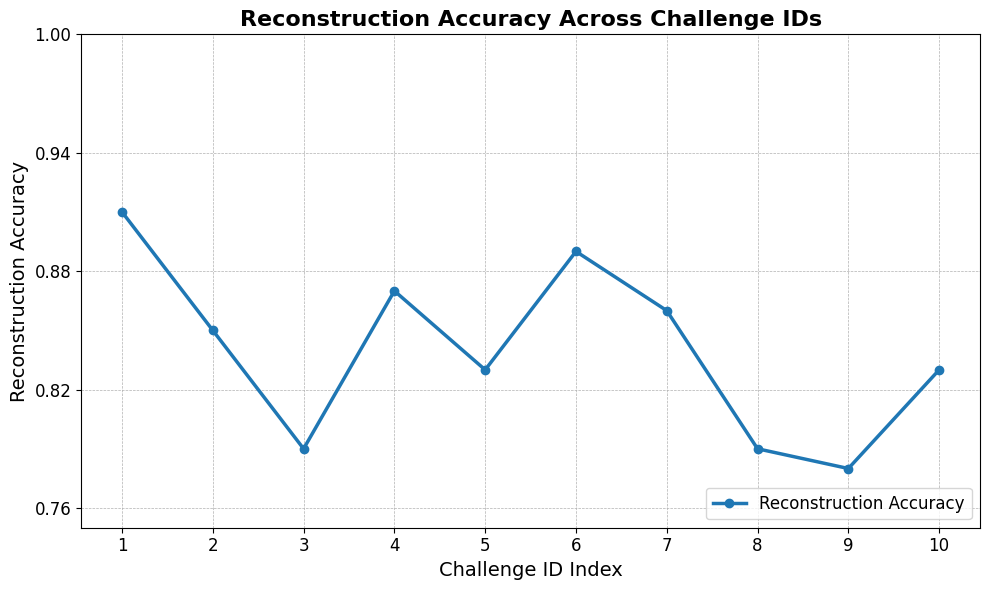

In [27]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

n = 100        
t = 2 * n       
lambda_ = 10    

# Generate challenge IDs
challenge_ids = [f'qazwsxc{i}' for i in range(1, 11)]

# Store reconstruction accuracy for each challenge id
reconstruction_accuracies = []

# Loop through each challenge ID
for idx, challenge_id in enumerate(challenge_ids):
    print(f"Processing challenge_id: {challenge_id}")

    # Generate random query matrix with -1 or 1
    queries = np.random.choice([-1, 1], size=(t, n))

    # Get noisy query results
    query_results = query(challenge_id, queries)

    num_vars = n + t 

    # Coefficients of the objective function
    c = np.hstack([np.zeros(n), np.ones(t)])

    A_ub = []
    b_ub = []

    for j in range(t):
        q = queries[j]
        y = query_results[j]
        
        # Constraints: ⟨q_j, x⟩ - y_j ≤ e_j
        A_row = np.hstack([q, np.zeros(t)])
        A_row[n + j] = -1
        A_ub.append(A_row)
        b_ub.append(y)
        
        # Constraints: -⟨q_j, x⟩ + y_j ≤ e_j
        A_row = np.hstack([-q, np.zeros(t)])
        A_row[n + j] = -1
        A_ub.append(A_row)
        b_ub.append(-y)

    A_ub = np.array(A_ub)
    b_ub = np.array(b_ub)

    # Bounds
    bounds = [(-1, 1)] * n + [(0, None)] * t

    # linear
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    if result.success:
        x_estimated = result.x[:n]
        x_reconstructed = np.sign(x_estimated)
    else:
        print("LP solving failed.")
        x_reconstructed = np.random.choice([-1, 1], size=n)

    # Submit reconstructed x and get accuracy
    best_query_result = query(challenge_id, x_reconstructed, submit=True)
    accuracy = (1 + best_query_result / n) / 2
    print(f"Reconstruction accuracy: {accuracy * 100:.2f}%\n")

    # Save accuracy
    reconstruction_accuracies.append(accuracy)

# Plot reconstruction accuracy

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(challenge_ids) + 1), reconstruction_accuracies, marker='o', linestyle='-', color='#1f77b4', markersize=6, linewidth=2.5, label='Reconstruction Accuracy')
plt.title('Reconstruction Accuracy Across Challenge IDs', fontsize=16, weight='bold')
plt.xlabel('Challenge ID Index', fontsize=14)
plt.ylabel('Reconstruction Accuracy', fontsize=14)
plt.xticks(range(1, len(challenge_ids) + 1), range(1, len(challenge_ids) + 1), fontsize=12)
plt.yticks(np.linspace(0.7, 1, 6), fontsize=12)
plt.ylim(0.75, 1)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.savefig('reconstruction_accuracy_top_journal.png', dpi=300)

# Show plot
plt.show()
